# Table of Contents

1. [Importing Necessary Dependencies](#importing-necessary-dependencies)
2. [Loading the Datasets](#loading-the-datasets)
3. [Defining Helper Functions](#defining-helper-functions)
4. [Data Preprocessing](#data-preprocessing)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)

# Importing Necessary Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.utils import class_weight

# Loading the Datasets

In [2]:
X_train = pd.read_parquet('../data/processed/X_train.parquet')
X_test = pd.read_parquet('../data/processed/X_test.parquet')
y_train = pd.read_parquet('../data/processed/y_train.parquet')
y_test = pd.read_parquet('../data/processed/y_test.parquet')

In [3]:
X_train.drop(columns="code_snippet", inplace=True)
X_test.drop(columns="code_snippet", inplace=True)

In [4]:
X_train.head()

,loc,num_args,num_returns,num_variables,num_function_calls,has_decorators,uses_globals,is_recursive,estimated_difficulty,estimated_bugs,has_docstring,docstring_length,num_comments,name_length,is_name_well_formed,bad_variable_names_count,max_return_length,estimated_complexity
0,2.0,1.0,0,0,1,False,False,False,0.000000,0.000000,False,0,0.0,46.0,True,0.0,0.0,1.0
1,13.0,1.0,0,7,6,False,False,False,1.250000,0.016610,False,0,0.0,13.0,True,0.0,0.0,1.0
2,4.0,1.0,0,0,2,False,False,False,0.000000,0.000000,False,0,1.0,16.0,True,0.0,0.0,1.0
3,67.0,2.0,2,28,38,False,False,False,4.442308,0.084073,True,3,6.0,14.0,True,11.0,125.0,9.0
4,6.0,2.0,0,0,5,True,False,False,0.000000,0.000000,False,0,0.0,35.0,False,0.0,0.0,1.0


In [5]:
y_train.head()

,quality
0,good
1,bad
2,good
3,bad
4,good


In [6]:
X_train = X_train[~X_train.duplicated()]
X_test = X_test[~X_test.duplicated()]

train_keep_indices = X_train.index
test_keep_indices = X_test.index

# Filter y_train and y_test to match the deduplicated X's
y_train = y_train.loc[train_keep_indices]
y_test = y_test.loc[test_keep_indices]

In [7]:
X_train.describe()

,loc,num_args,num_returns,num_variables,num_function_calls,estimated_difficulty,estimated_bugs,docstring_length,num_comments,name_length,bad_variable_names_count,max_return_length,estimated_complexity
count,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000,176967.000000
mean,18.513926,1.831053,0.769449,3.499698,7.981974,0.767141,0.007568,2.052371,1.116768,18.922584,0.957958,20.059226,2.541084
std,25.612529,1.665070,1.197201,5.172238,10.305177,1.364084,0.025296,9.490253,3.185020,11.655740,2.129401,62.775364,3.502940
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,5.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,11.000000,1.000000,1.000000,2.000000,5.000000,0.500000,0.000667,0.000000,0.000000,17.000000,0.000000,1.000000,1.000000
75%,22.000000,2.000000,1.000000,5.000000,10.000000,1.000000,0.005170,0.000000,1.000000,26.000000,1.000000,26.000000,3.000000
max,858.000000,55.000000,65.000000,226.000000,503.000000,56.875000,1.448993,449.000000,150.000000,295.000000,216.000000,12370.000000,182.000000


In [8]:
y_train.describe()

,quality
count,176967
unique,2
top,bad
freq,108560


In [9]:
X_train.dtypes

loc                         float64
num_args                    float64
num_returns                   int64
num_variables                 int64
num_function_calls            int64
has_decorators                 bool
uses_globals                   bool
is_recursive                   bool
estimated_difficulty        float64
estimated_bugs              float64
has_docstring                  bool
docstring_length              int64
num_comments                float64
name_length                 float64
is_name_well_formed            bool
bad_variable_names_count    float64
max_return_length           float64
estimated_complexity        float64
dtype: object

In [10]:
y_train.dtypes

quality    category
dtype: object

# Defining Helper Functions

In [11]:
def plot_learning_curve(model, X, y, cv=5, title="Learning Curve"):
	train_sizes, train_scores, val_scores = learning_curve(
		model, X, y, cv=cv, scoring='accuracy',
		train_sizes=np.linspace(0.1, 1.0, 10),
		n_jobs=-1
	)
	
	plt.figure(figsize=(10, 6))
	plt.plot(
		train_sizes, np.mean(train_scores, axis=1), label='Training Score'
	)
	plt.plot(
		train_sizes, np.mean(val_scores, axis=1), label='Validation Score'
	)
	plt.fill_between(
		train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
		np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1
	)
	plt.fill_between(
		train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
		np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1
	)
	
	plt.title(title)
	plt.xlabel("Training Examples")
	plt.ylabel("Accuracy Score")
	plt.legend()
	plt.grid()
	plt.show()

# Data Preprocessing

## Converting Boolean Columns to Numerical (0, 1)

In [12]:
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

## Scaling the Data

### Identifying numerical columns (excluding boolean/binary columns)

In [13]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in bool_cols]

### Scaling

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('bool', 'passthrough', bool_cols)  # Skip scaling for boolean columns
    ],
    remainder='passthrough'  # This will handle any other columns if they exist
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

### Converting to DataFrame to maintain column names

In [15]:
feature_names = numerical_cols + list(bool_cols)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## Encoding the Target Variable

In [16]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.squeeze())

## Calculating Class Weights
This step is optional, but can help balance the dataset and improve the model's performance.

In [17]:
classes = np.unique(y_train_encoded)
weights = class_weight.compute_sample_weight('balanced', y_train_encoded)
weights

array([1.29348605, 0.8150654 , 1.29348605, ..., 0.8150654 , 0.8150654 ,
       0.8150654 ], shape=(176967,))

# Model Training

In [18]:
model = RandomForestClassifier(
	n_estimators=200,          # Number of trees in the forest
	max_depth=200,              # Maximum depth of each tree
	min_samples_split=2,       # Minimum number of samples required to split a node
	min_samples_leaf=1,        # Minimum number of samples required at each leaf node
	max_features='sqrt',       # Number of features to consider at each split
	bootstrap=True,            # Whether bootstrap samples are used (bagging)
	random_state=42,           # For reproducibility
	n_jobs=-1,                 # Use all processors
	class_weight='balanced',   # Adjust weights inversely proportional to class frequencies
    verbose=True
)

model.fit(
	X_train_scaled,
	y_train_encoded
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   39.2s finished


RandomForestClassifier(class_weight='balanced', max_depth=200, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=True)

# Model Evaluation

In [19]:
y_pred_encoded = model.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.6s finished


              precision    recall  f1-score   support

         bad       0.85      0.89      0.87     28032
        good       0.83      0.77      0.80     19579

    accuracy                           0.84     47611
   macro avg       0.84      0.83      0.83     47611
weighted avg       0.84      0.84      0.84     47611



In [20]:
scores = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 task

Cross-validation scores: [0.83341809 0.83104481 0.82699969 0.82894923 0.82112282]
Mean cross-validation score: 0.8283069281332279


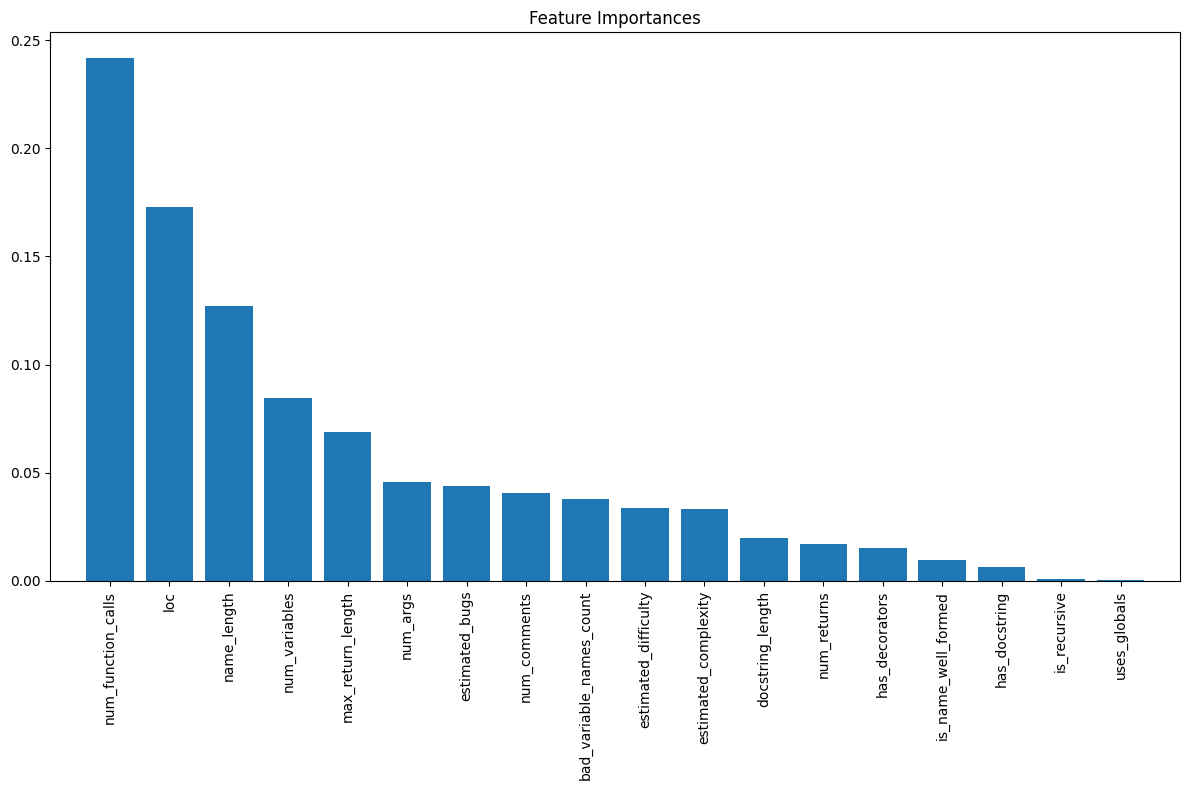

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.tight_layout()
plt.show()

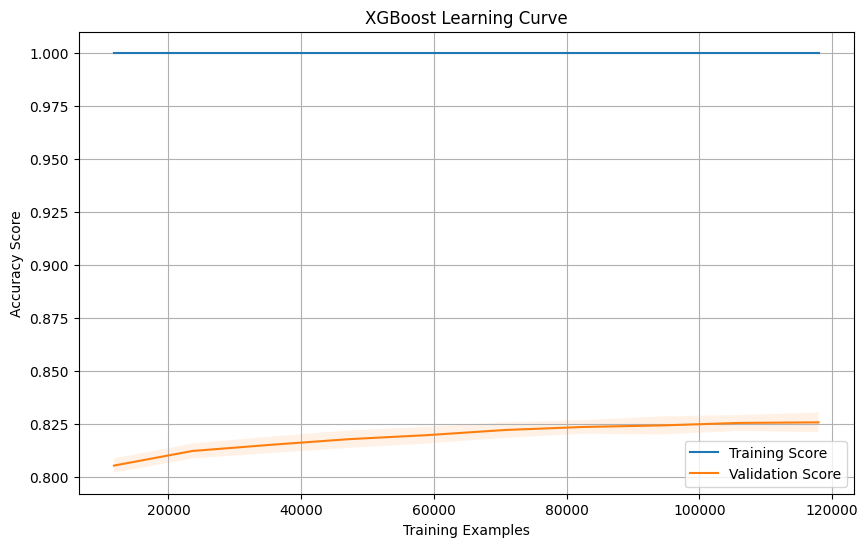

In [ ]:
plot_learning_curve(model, X_train_scaled, y_train_encoded, cv=3, title="RandomForestRegression Learning Curve")